In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bandit import NormalMultiArmedBandit, BernoulliMultiArmedBandit, BernoulliMultiArmedBandit_TaskDistribution
from agents import Agent, EpsilonGreedy, UCB_Agent
from train_test_bandits import generate_dataset
from model_bandits import DecisionTransformer, train


In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def averaging_reward(x):
    cumsum = np.cumsum(x)
    return cumsum / np.arange(1, len(x) + 1)

In [3]:
scale = 1.5
k = 11
means = np.array([0,1,2,3,4,5,6,7,8,9, 14])
sigmas = np.ones(k) * scale
MAbandit = NormalMultiArmedBandit(k, means, sigmas)

In [4]:
dataset = {action:[] for action in range(k)}
num_runs = 1000
for action in range(k):
    for _ in range(num_runs):
        dataset[action].append(MAbandit.run(action))
    dataset[action] = np.array(dataset[action])

In [5]:
rewards = []
episodes = 10000
random_agent = Agent(k)
for _ in range(episodes):
    action = random_agent.act()
    reward = MAbandit.run(action)
    rewards.append(reward)
rewards = np.array(rewards)
running_mean_rewards = averaging_reward(rewards) #np.convolve(rewards, np.ones(episodes) / episodes, mode = 'valid')

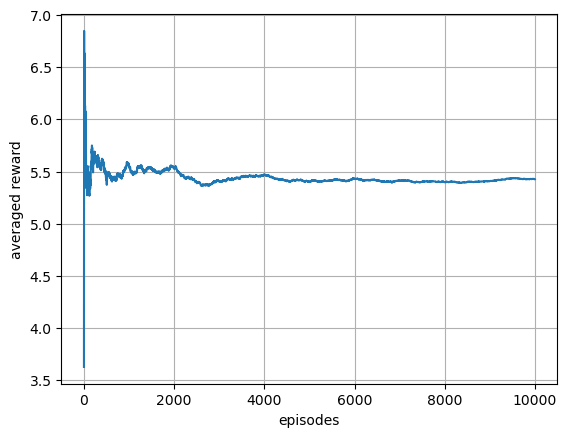

In [6]:
plt.plot(np.arange(episodes), running_mean_rewards)
# plt.ylim([3, 6])
plt.xlabel('episodes')
plt.ylabel('averaged reward')
plt.grid(True)
plt.show()

In [7]:
# plt.plot(np.arange(episodes), np.convolve(rewards, np.ones(100) / 100, mode = 'same'))
# plt.ylim([3, 6])
# plt.grid(True)
# plt.show()

In [8]:
epsilon = 0.1
rewards = []
episodes = 1000
epsilon_agent = EpsilonGreedy(k, epsilon)
for _ in range(episodes):
    action = epsilon_agent.act()
    reward = MAbandit.run(action)
    epsilon_agent.update_policy(action, reward)
    rewards.append(reward)
rewards = np.array(rewards)
running_mean_rewards = averaging_reward(rewards) #np.convolve(rewards, np.ones(episodes) / episodes, mode = 'valid')

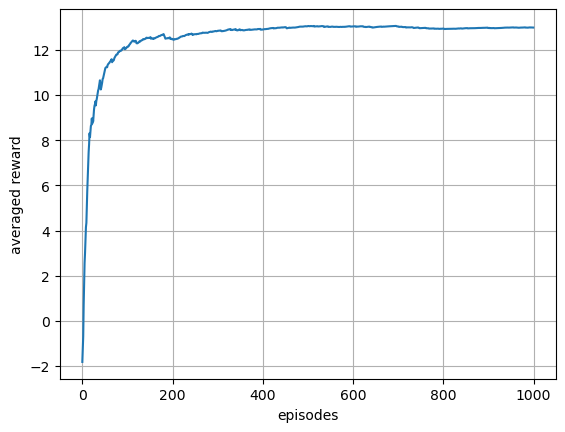

In [9]:
plt.plot(np.arange(episodes), running_mean_rewards)
plt.xlabel('episodes')
plt.ylabel('averaged reward')
plt.grid(True)
plt.show()

In [10]:
rewards[-200:].mean()

13.184091285843666

In [11]:
epsilon = 0.05
rewards = []
episodes = 1000
epsilon_agent = UCB_Agent(k, epsilon)
for _ in range(episodes):
    action = epsilon_agent.act()
    reward = MAbandit.run(action)
    epsilon_agent.update_policy(action, reward)
    rewards.append(reward)
rewards = np.array(rewards)
running_mean_rewards = averaging_reward(rewards) #np.convolve(rewards, np.ones(episodes) / episodes, mode = 'valid')

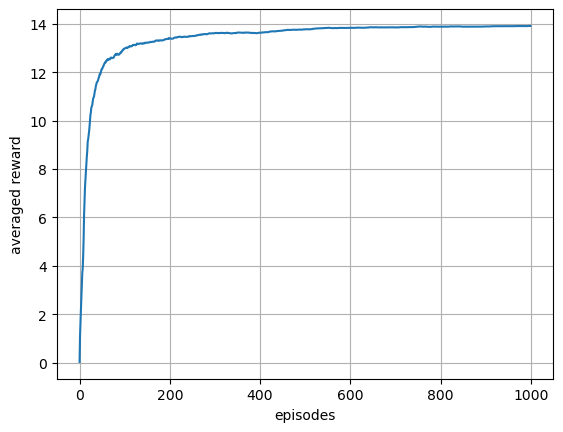

In [12]:
plt.plot(np.arange(episodes), running_mean_rewards)
plt.xlabel('episodes')
plt.ylabel('averaged reward')
plt.grid(True)
plt.show()

ps = [0.84286185 0.09572574 0.42896583 0.99922495 0.0176803  0.17069775
 0.80496188 0.5941419  0.0673023  0.88843596]


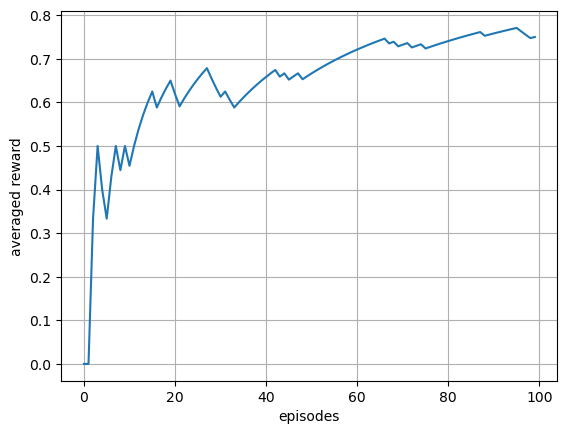

In [13]:
k=10
episodes = 100
delta = 0.9
ps = np.random.uniform(low=0, high=1, size=(k,))
print(f'ps = {ps}')
MAbandit = BernoulliMultiArmedBandit(k, ps)
rewards = []
# episodes = 1000

rewards = []
actions = []
ucb_agent = UCB_Agent(k, delta)
for _ in range(episodes):
    action = ucb_agent.act()
    actions.append(action)
    reward = MAbandit.run(action)
    ucb_agent.update_policy(action, reward)
    rewards.append(reward)
rewards = np.array(rewards)
running_mean_rewards = averaging_reward(rewards)

plt.plot(np.arange(episodes), running_mean_rewards)
# plt.ylim([3, 6])
plt.xlabel('episodes')
plt.ylabel('averaged reward')
plt.grid(True)
plt.show()

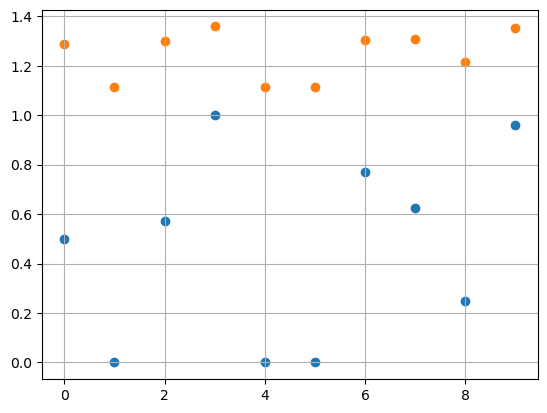

In [14]:
ucb_agent.plot_pseudo_rewards()

In [15]:
ucb_agent.print_pseudo_rewards()

pseudo_rewards =[1.28847827 1.11507666 1.3014176  1.3586463  1.11507666 1.11507666
 1.30489627 1.30784221 1.21568471 1.35257247]
self.rewards = [0.5, 0.0, 0.5714285714285714, 1.0, 0.0, 0.0, 0.7692307692307693, 0.625, 0.25, 0.9583333333333334]
self.states_counter = [6, 3, 7, 29, 3, 3, 13, 8, 4, 24]


In [16]:
n = 100
size = 40
k = 10
q = .95
distribution_type = 'odd'
delta = 0.9
agent = UCB_Agent(k, delta)
env_distr = BernoulliMultiArmedBandit_TaskDistribution()
dataset = generate_dataset(env_distr, agent, n, size)

In [17]:
dataset[0].keys()

dict_keys(['observations', 'actions', 'rewards'])

In [22]:
seq_len = 10
model = DecisionTransformer(
        state_dim=1,
        action_dim=1,
        seq_len = seq_len,
        episode_len = 1,
        embedding_dim = 16,
        num_layers = 4,
        num_heads = 4,
        max_action = 1,
        possible_actions = 10
    )
# train(model,
#       dataset,
#       subsequence_length=10,
#       num_epochs=100,
#       batch_size=10)

In [23]:
import torch
from torch.nn import functional as F

subsequence_length=7
num_epochs=1000
batch_size=10


losses = []
model.train()
optim = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lambda steps: min((steps + 1) / 10, 1))
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")


for _ in range(num_epochs):
    indexes = list(np.random.choice(np.arange(len(dataset)), size=batch_size))
    chosen_histories = [dataset[i] for i in indexes]
    j = np.random.randint(low=0, high=len(chosen_histories[0]["observations"]) - subsequence_length, size=batch_size, dtype=int)
    states = np.stack([history["observations"][j[i]:j[i]+subsequence_length] for (i,history) in enumerate(chosen_histories)])
    actions = np.stack([history["actions"][j[i]:j[i]+subsequence_length] for (i,history) in enumerate(chosen_histories)])
    rewards = np.stack([history["rewards"][j[i]:j[i]+subsequence_length] for (i,history) in enumerate(chosen_histories)])
    if len(states.shape) < 3:
        states = torch.Tensor(states).unsqueeze(-1)
    if len(actions.shape) < 3:
        actions = torch.Tensor(actions).unsqueeze(-1)
    rewards = torch.Tensor(rewards)
    time_steps = torch.zeros((batch_size, subsequence_length), dtype=torch.long)
    mask = np.hstack(
            [np.ones((states.shape[0],states.shape[1])), np.zeros((states.shape[0], seq_len - states.shape[1]))]
        )
    mask = torch.Tensor(mask)
    padding_mask = ~mask.to(torch.bool)
    print(f'states = {states.shape}')
    print(f'actions = {actions.shape}')
    print(f'rewards = {rewards.shape}')
    output = model(states, actions, rewards, time_steps, padding_mask)
    # print(f'output.shape = {output.flatten(0, 1).shape}')
    # print(f'actions.shape = {actions.to(torch.long)}')
    loss = F.cross_entropy(
                    input=output.flatten(0, 1),
                    target=actions.flatten(0).to(torch.long),
                    )
    # loss = F.mse_loss(output, actions.detach(), reduction="none")
    # [batch_size, seq_len, action_dim] * [batch_size, seq_len, 1]
    # loss = (loss * mask.unsqueeze(-1)).mean()

    optim.zero_grad()
    loss.backward()
    # if config.clip_grad is not None:
    #     torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad)
    optim.step()
    scheduler.step()
    losses.append(loss.detach().numpy())


Total parameters: 13626
states = torch.Size([10, 7, 1])
actions = torch.Size([10, 7, 1])
rewards = torch.Size([10, 7])


RuntimeError: shape '[10, 21]' is invalid for input of size 300

In [20]:
output.shape

torch.Size([10, 10, 10])